In [9]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.impute import SimpleImputer
import shap
import matplotlib.pyplot as plt
import seaborn as sns

###########################################
# 1. Load and Preprocess the Training Data
###########################################

# Load the training data from sweetspot_optimized.csv
df = pd.read_csv('sweetspot_optimized.csv')

# Rename columns for convenience
df.rename(columns={
    'Well Number': 'well_number',
    'Well Name': 'well_name',
    'Bottomhole X': 'x',
    'Bottomhole Y': 'y',
    'Co [MSTB]': 'oil_production',      # target variable
    'Cw (bbl)': 'water_production',
    'POROS': 'porosity',
    'KX': 'kx',
    'KY': 'ky',
    'TD(MD)': 'td',
    'Cg (mmcf)': 'gas_production',
    'P_2020-1-6': 'p_2020_1_6',
    'P_2029-1-1': 'p_2029_1_1',
    'RQI': 'rqi',
    'Pressure_Drawdown': 'pressure_drawdown',
    'OGR': 'ogr',
    'Facies_1': 'facies_1',
    'Facies_2': 'facies_2',
    'Facies_3': 'facies_3',
    'Facies_4': 'facies_4',
    'Facies_5': 'facies_5'
}, inplace=True)

print("Training data columns:")
print(df.columns.tolist())

# Use spatial coordinates 'x' and 'y'
coords = df[['x', 'y']].values

# Set number of nearest neighbors to include for RFSI features
n_neighbors = 25

# Build NearestNeighbors model on the training coordinates
nbrs_model = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto').fit(coords)
# Compute nearest neighbors
distances, indices = nbrs_model.kneighbors(coords)

# Create neighbor features: for each well, add oil production and distance of each neighbor
for i in range(n_neighbors):
    df[f'nb_{i+1}_prod'] = df.iloc[indices[:, i]]['oil_production'].values
    df[f'nb_{i+1}_dist'] = distances[:, i]

Training data columns:
['well_number', 'well_name', 'x', 'y', 'oil_production', 'water_production', 'porosity', 'kx', 'ky', 'td', 'gas_production', 'p_2020_1_6', 'p_2029_1_1', 'rqi', 'pressure_drawdown', 'ogr', 'facies_1', 'facies_2', 'facies_3', 'facies_4', 'facies_5']


In [3]:
###########################################
# 2. Prepare Feature Matrix and Impute Missing Values
###########################################

# Define target variable: we predict oil production
y = df['oil_production']

# Exclude columns that should not be used as predictors
features_to_exclude = ['well_number', 'well_name', 'oil_production']
X = df.drop(columns=features_to_exclude)

print("\nPredictor columns:")
print(X.columns.tolist())

# Impute missing values using mean imputation
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)


Predictor columns:
['x', 'y', 'water_production', 'porosity', 'kx', 'ky', 'td', 'gas_production', 'p_2020_1_6', 'p_2029_1_1', 'rqi', 'pressure_drawdown', 'ogr', 'facies_1', 'facies_2', 'facies_3', 'facies_4', 'facies_5', 'nb_1_prod', 'nb_1_dist', 'nb_2_prod', 'nb_2_dist', 'nb_3_prod', 'nb_3_dist', 'nb_4_prod', 'nb_4_dist', 'nb_5_prod', 'nb_5_dist', 'nb_6_prod', 'nb_6_dist', 'nb_7_prod', 'nb_7_dist', 'nb_8_prod', 'nb_8_dist', 'nb_9_prod', 'nb_9_dist', 'nb_10_prod', 'nb_10_dist', 'nb_11_prod', 'nb_11_dist', 'nb_12_prod', 'nb_12_dist', 'nb_13_prod', 'nb_13_dist', 'nb_14_prod', 'nb_14_dist', 'nb_15_prod', 'nb_15_dist', 'nb_16_prod', 'nb_16_dist', 'nb_17_prod', 'nb_17_dist', 'nb_18_prod', 'nb_18_dist', 'nb_19_prod', 'nb_19_dist', 'nb_20_prod', 'nb_20_dist', 'nb_21_prod', 'nb_21_dist', 'nb_22_prod', 'nb_22_dist', 'nb_23_prod', 'nb_23_dist', 'nb_24_prod', 'nb_24_dist', 'nb_25_prod', 'nb_25_dist']



Model Evaluation on Test Set:
R2: 0.98590524874849
MAE: 3.8538960777454467
RMSE: 4.703058937513594


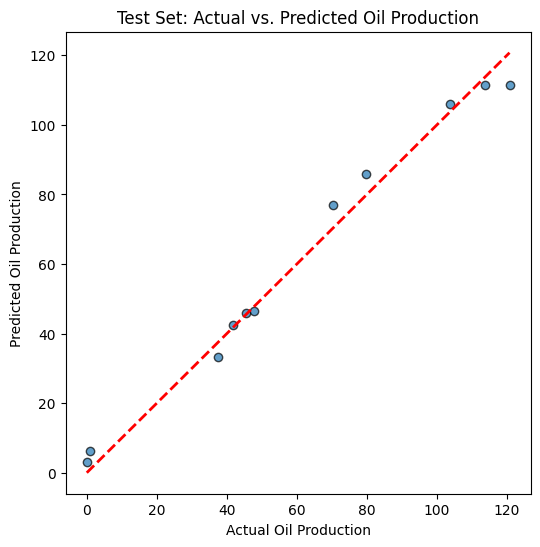

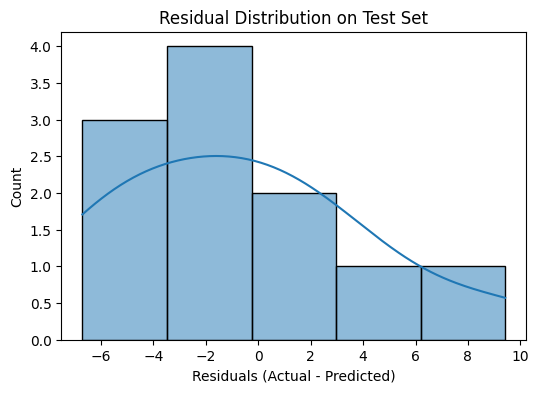

In [10]:
# 3. Train/Test Split and Model Training
###########################################

X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Train a Random Forest regressor (using 250 trees)
rf = RandomForestRegressor(n_estimators=250, random_state=42)
rf.fit(X_train, y_train)

# Predict on the test set
y_pred = rf.predict(X_test)

# Evaluation metrics
print("\nModel Evaluation on Test Set:")
print("R2:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

###########################################
# 3a. Verification: Visualization on Test Set
###########################################

# Scatter plot: Actual vs. Predicted on the test set
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.7, edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Oil Production")
plt.ylabel("Predicted Oil Production")
plt.title("Test Set: Actual vs. Predicted Oil Production")
plt.show()

# Residual Histogram
residuals = y_test - y_pred
plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True)
plt.xlabel("Residuals (Actual - Predicted)")
plt.title("Residual Distribution on Test Set")
plt.show()


Base feature columns (excluding neighbor features):
['x', 'y', 'water_production', 'porosity', 'kx', 'ky', 'td', 'gas_production', 'p_2020_1_6', 'p_2029_1_1', 'rqi', 'pressure_drawdown', 'ogr', 'facies_1', 'facies_2', 'facies_3', 'facies_4', 'facies_5']

Predictions for all candidate locations have been saved to 'rfsi_predictions_all_locations.csv'.


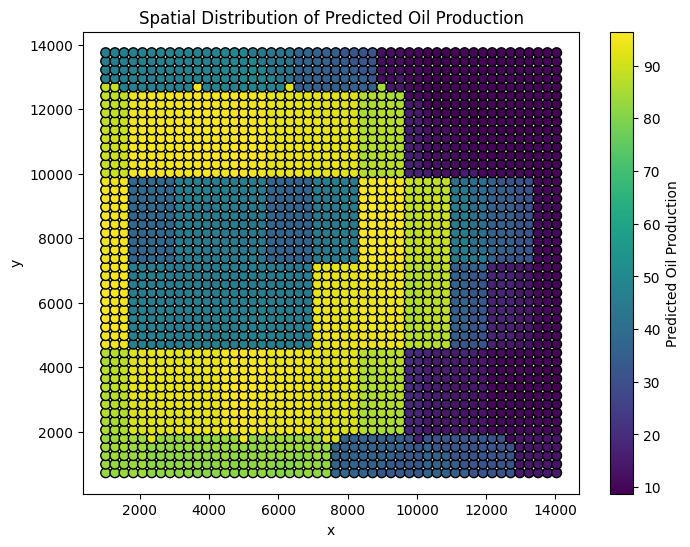

In [12]:
###########################################
# 5. Generate Candidate Locations (Grid) and Predict
###########################################

# Since we don't have a file for candidate locations, create a grid covering the study area.
x_min, x_max = df['x'].min(), df['x'].max()
y_min, y_max = df['y'].min(), df['y'].max()

# Define grid resolution (adjust as needed)
num_points_x = 50  # points in x-direction
num_points_y = 50  # points in y-direction

x_vals = np.linspace(x_min, x_max, num_points_x)
y_vals = np.linspace(y_min, y_max, num_points_y)
grid_x, grid_y = np.meshgrid(x_vals, y_vals)

# Create candidate locations DataFrame (with 'x' and 'y')
candidate_df = pd.DataFrame({
    'x': grid_x.ravel(),
    'y': grid_y.ravel()
})

# For candidate locations, fill additional base environmental/geologic features using the training mean.
# Determine base feature columns (those not starting with 'nb_')
base_feature_cols = [col for col in X_imputed.columns if not col.startswith('nb_')]
print("\nBase feature columns (excluding neighbor features):")
print(base_feature_cols)

for col in base_feature_cols:
    if col not in ['x', 'y']:
        candidate_df[col] = X_imputed[col].mean()

# Generate spatial neighbor features for candidate locations using the training nbrs_model.
new_coords = candidate_df[['x', 'y']].values
dist_new, ind_new = nbrs_model.kneighbors(new_coords, n_neighbors=n_neighbors)

# Retrieve oil production values from training data for these neighbor indices.
# Use direct indexing on the one-dimensional oil production array.
nb_prods_new = df['oil_production'].values[ind_new]

# Append neighbor features to candidate_df.
for i in range(n_neighbors):
    candidate_df[f'nb_{i+1}_prod'] = nb_prods_new[:, i]
    candidate_df[f'nb_{i+1}_dist'] = dist_new[:, i]

# Ensure candidate_df has the same predictor columns as used in training.
features_list = X_imputed.columns

# Impute any missing values in candidate_df using the same imputer
candidate_df_imputed = pd.DataFrame(imputer.transform(candidate_df[features_list]), columns=features_list)

# Predict oil production for candidate locations
candidate_predictions = rf.predict(candidate_df_imputed)
candidate_df['predicted_oil_production'] = candidate_predictions

# Save candidate predictions to CSV
candidate_df.to_csv('rfsi_predictions_all_locations.csv', index=False)
print("\nPredictions for all candidate locations have been saved to 'rfsi_predictions_all_locations.csv'.")

###########################################
# 5a. Visualization of Candidate Predictions
###########################################

# Visualize candidate predictions on a scatter plot (colored by predicted oil production)
plt.figure(figsize=(8,6))
sc = plt.scatter(candidate_df['x'], candidate_df['y'], c=candidate_df['predicted_oil_production'], 
                 cmap='viridis', s=50, edgecolor='k')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Spatial Distribution of Predicted Oil Production")
plt.colorbar(sc, label="Predicted Oil Production")
plt.show()